In [53]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_validate, GridSearchCV, train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from catboost import CatBoostClassifier, utils
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures, OrdinalEncoder, OneHotEncoder, StandardScaler, RobustScaler, LabelEncoder
from sklearn.base import BaseEstimator, TransformerMixin
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score,make_scorer, accuracy_score, f1_score, recall_score, classification_report
import seaborn as sns
import optuna

In [54]:
df = pd.read_csv('dataset.csv')
df['NewExist'] = df['NewExist'].fillna(0)

In [62]:
features_of_interest = [
    'State','cat_activites', 'UrbanRural','LowDoc','bank_loan_float','SBA_loan_float','FranchiseCode','BankState','RevLineCr','Term','crisis',
    'MIS_Status'
]

numerical_column = ['bank_loan_float','SBA_loan_float','Term'
    
]


ordinal_column = [
    'LowDoc',
]

categorical_column = [
    'State','cat_activites','FranchiseCode','BankState','RevLineCr',
]


target_name = "MIS_Status"
data, target, numerical_data, ordinal_data, categorical_data = (
    df[features_of_interest],
    df[target_name],
    df[numerical_column],
    df[ordinal_column],
    df[categorical_column]
)

In [ ]:
# df.dtypes
# df['ApprovalFY'] = pd.to_datetime(df['ApprovalFY'])

In [63]:
X_train, X_test, y_train, y_test = train_test_split(data, target,train_size=0.9, random_state=42, stratify=data['MIS_Status'])
# Retirer la colonne 'MIS_Status' des ensembles X_train et X_test (pour éviter le data leaking)
X_train = X_train.drop('MIS_Status', axis=1)
X_test = X_test.drop('MIS_Status', axis=1)


label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.fit_transform(y_test)

In [64]:
preprocessor = ColumnTransformer(
    [("categorical", OneHotEncoder(handle_unknown='ignore'), categorical_column),
    ("ordinal", OrdinalEncoder(), ordinal_column),
    ("numeric", StandardScaler(), numerical_column),
    ],
    remainder="passthrough",
)

In [93]:
clf = make_pipeline(preprocessor,CatBoostClassifier(n_estimators=194, max_depth = 16, learning_rate=0.2598358030410219, l2_leaf_reg= 6.404008626220454 ,subsample=0.8178075218065479,eval_metric='AUC')) # modele meilleur avec le polynomialfeatures mais pour les graphiques faire sans
clf.fit(X_train, y_train_encoded)


0:	total: 2.67s	remaining: 8m 36s
1:	total: 5.31s	remaining: 8m 30s
2:	total: 8.31s	remaining: 8m 49s
3:	total: 11.9s	remaining: 9m 25s
4:	total: 15.1s	remaining: 9m 29s
5:	total: 17.8s	remaining: 9m 18s
6:	total: 21.1s	remaining: 9m 22s
7:	total: 24.5s	remaining: 9m 30s
8:	total: 27.9s	remaining: 9m 32s
9:	total: 31.3s	remaining: 9m 35s
10:	total: 34.8s	remaining: 9m 38s
11:	total: 38.2s	remaining: 9m 39s
12:	total: 41.4s	remaining: 9m 35s
13:	total: 44.3s	remaining: 9m 29s
14:	total: 48s	remaining: 9m 33s
15:	total: 51.8s	remaining: 9m 36s
16:	total: 54.9s	remaining: 9m 31s
17:	total: 57.3s	remaining: 9m 19s
18:	total: 60s	remaining: 9m 12s
19:	total: 1m 2s	remaining: 9m 5s
20:	total: 1m 5s	remaining: 8m 58s
21:	total: 1m 7s	remaining: 8m 50s
22:	total: 1m 10s	remaining: 8m 45s
23:	total: 1m 13s	remaining: 8m 38s
24:	total: 1m 15s	remaining: 8m 31s
25:	total: 1m 18s	remaining: 8m 24s
26:	total: 1m 21s	remaining: 8m 25s
27:	total: 1m 24s	remaining: 8m 22s
28:	total: 1m 28s	remaining: 

/home/zerrouk/Documents/Simplon/brief_pret/brief_loan/.venv/lib/python3.12/site-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categorical',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['State', 'cat_activites',
                                                   'FranchiseCode', 'BankState',
                                                   'RevLineCr']),
                                                 ('ordinal', OrdinalEncoder(),
                                                  ['LowDoc']),
                                                 ('numeric', StandardScaler(),
                                                  ['bank_loan_float',
                                                   'SBA_loan_float',
                                                   'Term'])])),
                ('catboostclassifier',
                 <catboost.core.CatBoostClassifier object at 0x74689967b9e0>)])

In [94]:
# Si c'est un problème binaire, prenez la probabilité pour la classe 1 (classe positive)
proba = clf.predict_proba(X_test)[:, 1]
y_pred = clf.predict(X_test)
# Calcul du score AUC-ROC
roc_auc = roc_auc_score(y_test_encoded, proba)
print("AUC-ROC score:", roc_auc)
print('accuracy', clf.score(X_test,y_test_encoded))
print('rappel', recall_score(y_test_encoded,y_pred))
print('f1_score',f1_score(y_test_encoded,y_pred))
print(classification_report(y_test_encoded,y_pred))

AUC-ROC score: 0.9799388524038966
accuracy 0.9503764582893113
rappel 0.9757874148512848
f1_score 0.9700822035375682
              precision    recall  f1-score   support

           0       0.88      0.83      0.85     15782
           1       0.96      0.98      0.97     74135

    accuracy                           0.95     89917
   macro avg       0.92      0.90      0.91     89917
weighted avg       0.95      0.95      0.95     89917



In [95]:
df_rf = pd.DataFrame(clf[-1].feature_importances_,clf[0].get_feature_names_out())
df_rf=df_rf.transpose()
df_rf.columns

Index(['categorical__State_AK', 'categorical__State_AL',
       'categorical__State_AP', 'categorical__State_AR',
       'categorical__State_AZ', 'categorical__State_CA',
       'categorical__State_CO', 'categorical__State_CT',
       'categorical__State_DC', 'categorical__State_DE',
       ...
       'categorical__RevLineCr_T', 'categorical__RevLineCr_Y',
       'categorical__RevLineCr_`', 'categorical__RevLineCr_nan',
       'ordinal__LowDoc', 'numeric__bank_loan_float',
       'numeric__SBA_loan_float', 'numeric__Term', 'remainder__UrbanRural',
       'remainder__crisis'],
      dtype='object', length=2832)

In [96]:
liste_sum = []
for column in data.columns:
    sum_column = 0


    for elem in df_rf:
       if column in f'_{elem}_':
           sum_column += df_rf[elem]

    df_rf[f'sum_{column}'] = sum_column
    liste_sum.append(f'sum_{column}')


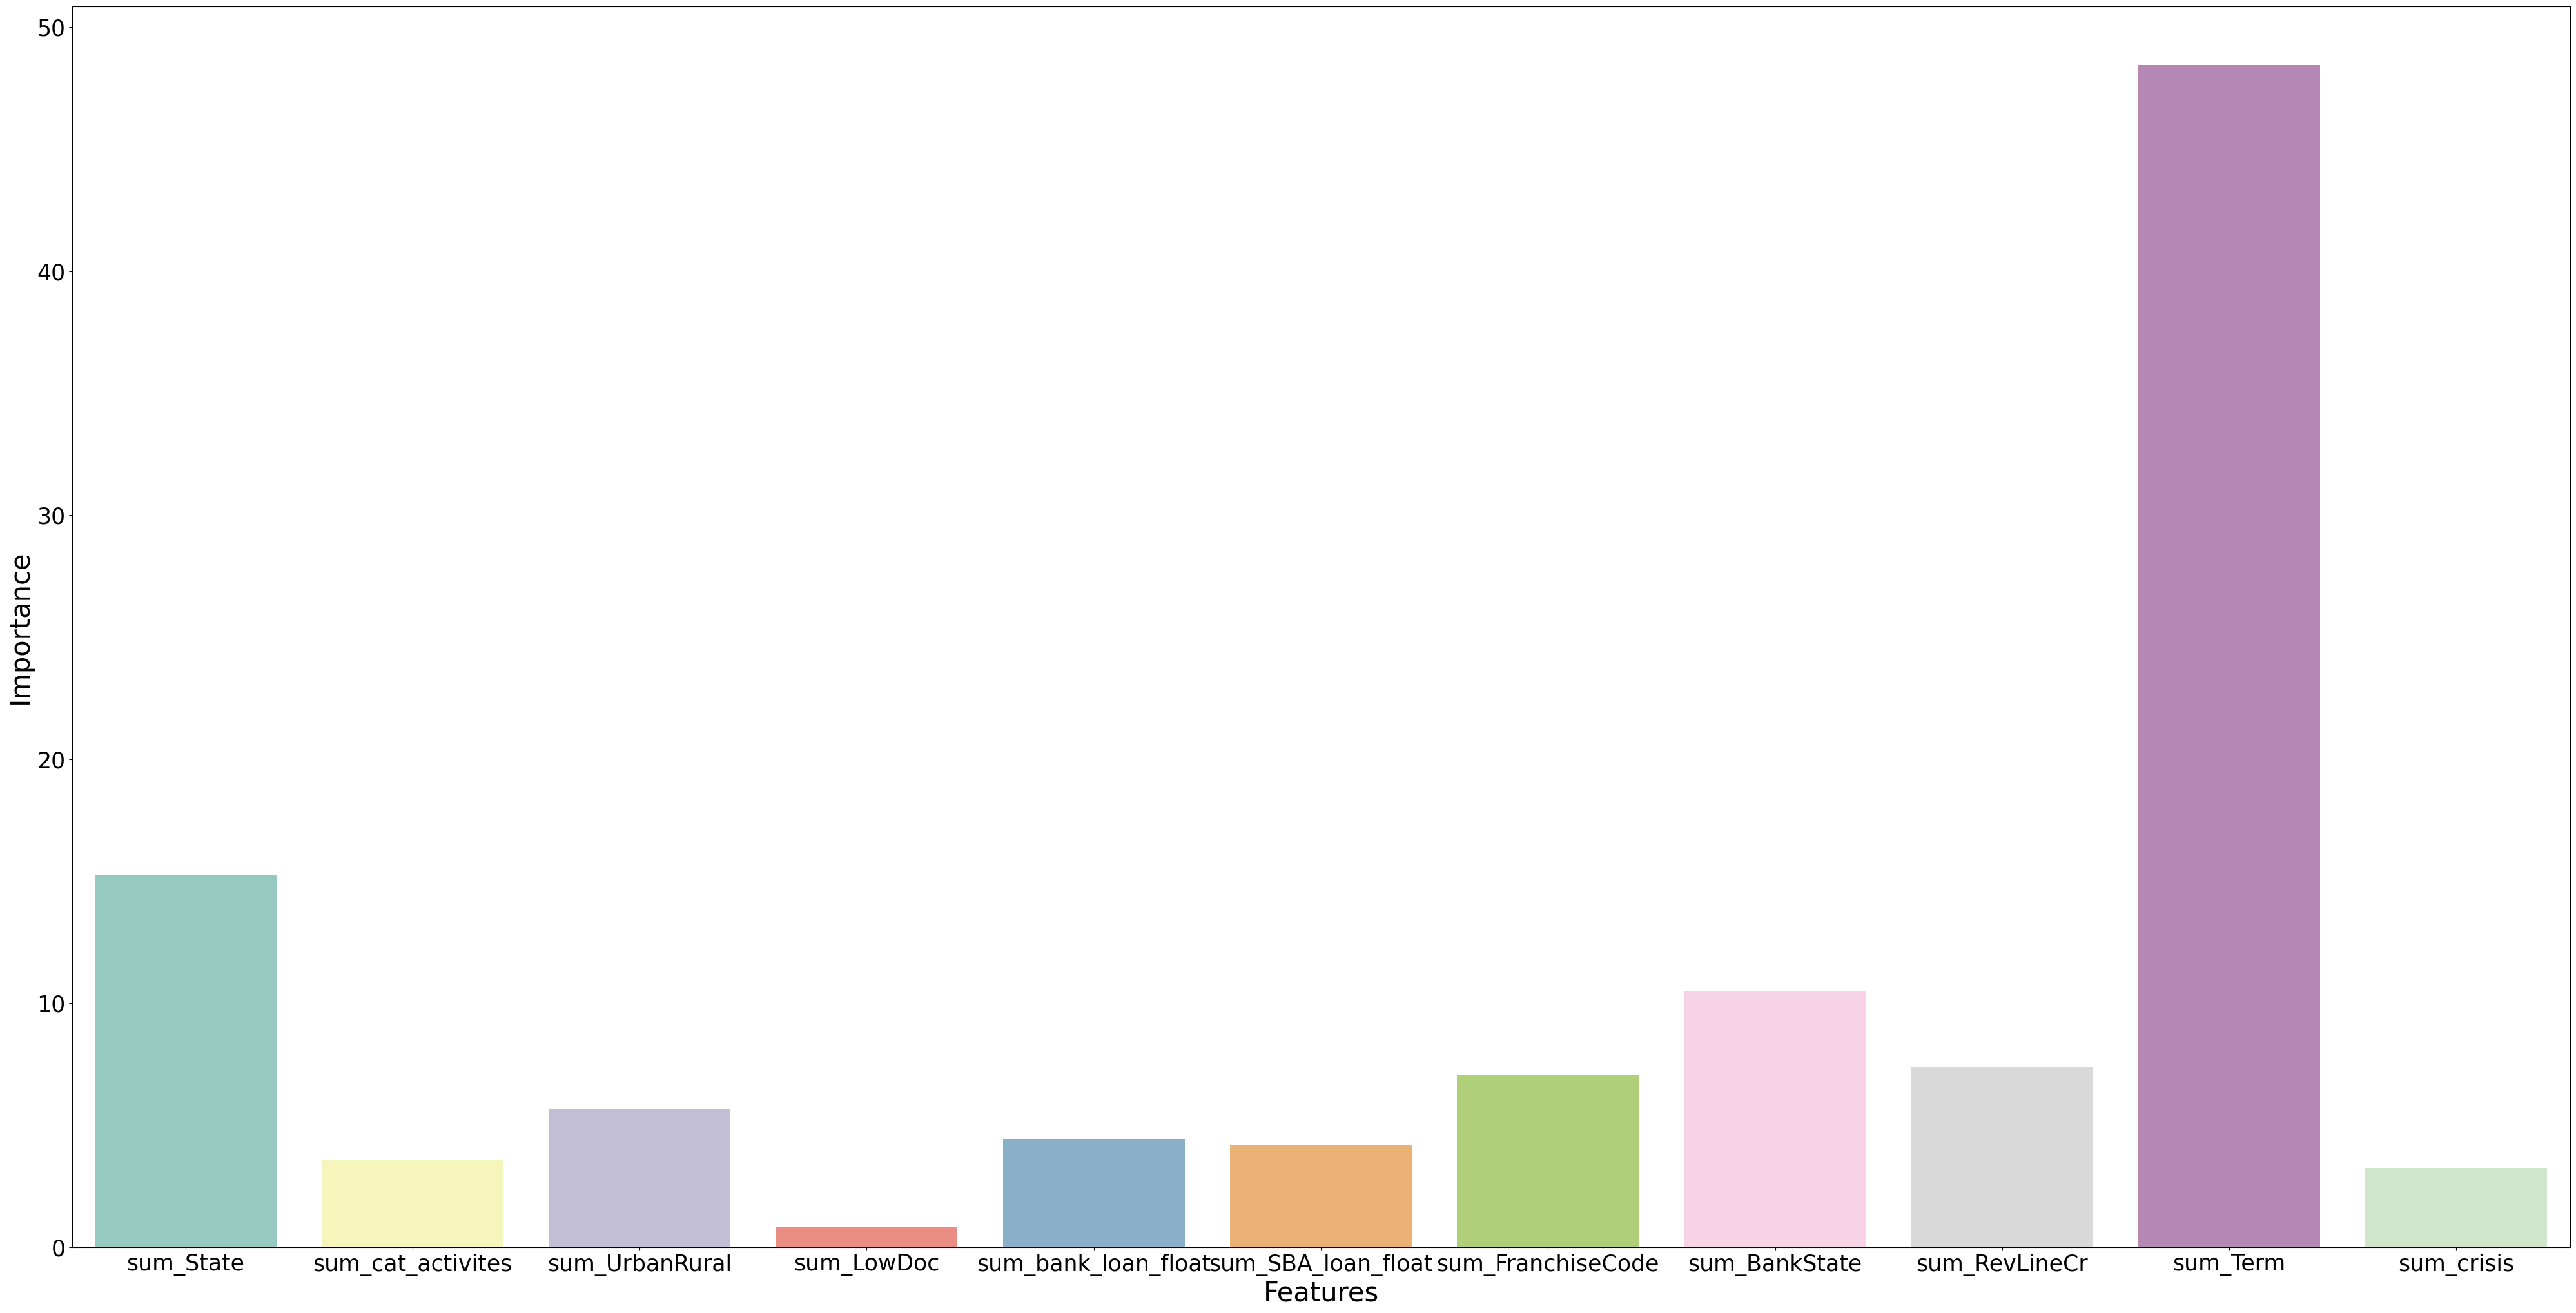

In [97]:


df_rf_graphique = df_rf[liste_sum]


plt.figure(figsize=(50, 25))
sns.barplot(data=df_rf_graphique.drop('sum_MIS_Status', axis = 1), palette="Set3")

# Augmenter la taille des labels des axes
plt.xlabel("Features", fontsize=30)
plt.ylabel("Importance", fontsize=30)

# Augmenter la taille des ticks des axes
plt.tick_params(axis='both', labelsize=25)
plt.show()

In [91]:
import optuna


In [92]:
def objective(trial):
    # Définir les hyperparamètres à optimiser
    n_estimators = trial.suggest_int('n_estimators', 50, 200)
    max_depth = trial.suggest_int('max_depth', 4, 16)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3, log=True)
    l2_leaf_reg = trial.suggest_float('l2_leaf_reg', 1, 10)
    subsample = trial.suggest_float('subsample', 0.6, 1.0)
    
    # Créer le modèle de classification avec les hyperparamètres choisis
    clf = make_pipeline(preprocessor,CatBoostClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        l2_leaf_reg=l2_leaf_reg,
        subsample=subsample,
        random_state=42,
        verbose=0,  # Pas de sortie de logs pendant l'entraînement
        early_stopping_rounds=50,  # Arrêt précoce si la performance ne s'améliore pas
        thread_count=4  # Limiter l'utilisation à 4 cœurs
    )) 
    
    # Entraîner le modèle
    clf.fit(X_train, y_train_encoded)
    
    # Prédire sur le jeu de test et calculer l'accuracy
    y_pred = clf.predict(X_test)
    proba = clf.predict_proba(X_test)[:, 1]
    
    roc_auc = roc_auc_score(y_test_encoded, proba)
    
    return roc_auc
    
    # return accuracy

# Créer et lancer l'étude Optuna
study = optuna.create_study(direction='maximize')  # Maximiser l'accuracy
study.optimize(objective, n_trials=50)  # Essayer 10 différentes combinaisons d'hyperparamètres



# Afficher les meilleurs hyperparamètres et le meilleur score
print('Meilleurs hyperparamètres :', study.best_params)
print('Meilleur score d\'accuracy :', study.best_value)


[I 2025-02-12 09:54:16,620] A new study created in memory with name: no-name-e62c6de2-cb34-4ac4-a090-bd1e44becdcc
[I 2025-02-12 09:55:14,597] Trial 0 finished with value: 0.9652467588058676 and parameters: {'n_estimators': 167, 'max_depth': 12, 'learning_rate': 0.022121544424156873, 'l2_leaf_reg': 6.2764135676371335, 'subsample': 0.8514132560456915}. Best is trial 0 with value: 0.9652467588058676.
[I 2025-02-12 09:58:11,875] Trial 1 finished with value: 0.9685016277413057 and parameters: {'n_estimators': 115, 'max_depth': 15, 'learning_rate': 0.031122971997356873, 'l2_leaf_reg': 2.525771117693886, 'subsample': 0.9220122429820168}. Best is trial 1 with value: 0.9685016277413057.
[I 2025-02-12 10:00:13,798] Trial 2 finished with value: 0.9727258525623668 and parameters: {'n_estimators': 155, 'max_depth': 14, 'learning_rate': 0.04007196098939154, 'l2_leaf_reg': 3.9163335716562724, 'subsample': 0.9933514851024192}. Best is trial 2 with value: 0.9727258525623668.
[I 2025-02-12 10:00:23,124]

KeyboardInterrupt: 

n_estimators :
Ce paramètre définit le nombre total d'arbres (ou d'estimateurs) que le modèle va construire. Chaque arbre sert à améliorer la prédiction par rapport à l'arbre précédent. Un plus grand nombre d'estimateurs peut potentiellement améliorer la performance du modèle, mais aussi augmenter le risque de surapprentissage (overfitting).

max_depth :
Ce paramètre définit la profondeur maximale de chaque arbre. Une valeur plus élevée permet à l'arbre d'être plus complexe et de mieux s'adapter aux données, mais cela peut aussi entraîner un surapprentissage si la profondeur est trop grande. En général, une profondeur de 6 à 10 est souvent un bon compromis.

learning_rate :
Le taux d'apprentissage (ou learning rate) contrôle l'ampleur des ajustements apportés par chaque arbre à la prédiction. Un taux plus bas rend l'apprentissage plus lent, mais peut améliorer la généralisation du modèle, en particulier lorsqu'il est combiné avec un grand nombre d'arbres (n_estimators). À l'inverse, un taux trop élevé peut entraîner une mauvaise convergence.

l2_leaf_reg :
C'est la régularisation L2 appliquée aux feuilles des arbres. La régularisation L2 (ou Ridge) pénalise les grands coefficients dans le modèle, ce qui peut aider à éviter le surapprentissage. Une valeur plus élevée rend la régularisation plus forte et peut réduire la complexité du modèle, tandis qu'une valeur plus faible permet au modèle de s'adapter davantage aux données d'entraînement.

subsample :
Ce paramètre définit la proportion de données d'entraînement qui est utilisée pour entraîner chaque arbre. Si subsample est inférieur à 1, cela signifie qu'un sous-ensemble aléatoire des données est utilisé pour chaque arbre. Cela permet de réduire le surapprentissage et d'améliorer la généralisation, mais une valeur trop basse peut entraîner une perte d'information importante.

random_state :
Ce paramètre est utilisé pour assurer la reproductibilité des résultats. En spécifiant une valeur pour random_state, tu garantis que les mêmes données, les mêmes paramètres et la même séquence d'opérations entraîneront toujours les mêmes résultats. Cela permet de comparer les performances des modèles de manière cohérente.

verbose :
Ce paramètre contrôle la quantité d'informations affichées pendant l'entraînement. Lorsque verbose=0, aucune sortie n'est affichée. Si tu veux voir des informations sur le processus d'entraînement, comme la perte à chaque itération ou l'amélioration du modèle, tu peux augmenter la valeur de ce paramètre (par exemple, à 1 ou 2).

early_stopping_rounds :
Ce paramètre permet de stopper l'entraînement plus tôt si la performance du modèle (sur un ensemble de validation) ne s'améliore pas après un certain nombre de tours. Ici, avec early_stopping_rounds=50, l'entraînement s'arrêtera si la performance sur le jeu de validation n'a pas augmenté après 50 itérations successives. Cela aide à éviter le surapprentissage et à gagner du temps.

thread_count :
Ce paramètre détermine le nombre de threads (cœurs de processeur) utilisés pour entraîner le modèle en parallèle. Plus le nombre de threads est élevé, plus l'entraînement sera rapide, à condition que ton système dispose de suffisamment de ressources.